In [3]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset
from pyg_classifier.model import Diff_CG_Classifier
from pyg_classifier.test import diff_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = False
k = 3

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?

In [4]:
#Training
import time
start = time.perf_counter()

num_node_feats = training_dataset.num_node_features

seed = 11548656655743780201
th.manual_seed(seed)
th.cuda.manual_seed(seed)
#pyg.seed_everything(seed)
    
model = Diff_CG_Classifier(num_node_feats).to(device)

b_size = 64
train_dataloader = DenseDataLoader(training_dataset, batch_size=b_size, shuffle=True)
val_dataloader = DenseDataLoader(val_dataset, batch_size=b_size)

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=1000)
model.train()

epochs = 5000

@th.no_grad()
def val_loop(model, val_dataloader):
    model.eval()
    val_loss = 0
    mae_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred, vl, ve = model(v_data)
        v_loss = F.smooth_l1_loss(val_pred, v_data.y, reduction="mean") + vl + ve
        mae_l= F.l1_loss(val_pred, v_data.y, reduction="mean")
        mae_loss += mae_l.detach().item()
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    mae_loss /= (i + 1)
    return val_loss, mae_loss

#training setup
epoch_losses = []
val_losses = []
mae_losses = []
learning_rates = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred, l, e = model(data, model.training)
        loss = F.smooth_l1_loss(pred, data.y, reduction="mean")
        final_loss = loss + l + e #trying out simple combination
        final_loss.backward()
        opt.step()
        epoch_loss += final_loss.detach().item() #loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    #epoch_loss, l, e = training_loop(model, learning_rates, train_dataloader, scheduler, opt)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss, mae_loss = val_loop(model, val_dataloader)
    val_losses.append(val_loss)
    mae_losses.append(mae_loss)

    th.save(model.state_dict(), "pyg_diff_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Training loss {epoch_loss:.4f}, Validation loss {val_loss:.4f}, learning rate {scheduler.get_last_lr()[0]:.5f}")
        print(f"\t Validation MAE: {mae_loss:.4f}")
        
end = time.perf_counter()

print(f"Training took {(end - start)/60/60:.2f} hours")
print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")
print(f"Seed used for training was: {th.initial_seed()}")

#plot the training run
figure, ax = plt.subplots(layout="constrained", figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, "r")
ax.plot(mae_losses, "orange")
plt.title(f"Training Loss, seed: {th.initial_seed()}")
ax.set_ybound(lower=0, upper=20)
plt.draw()

Epoch 0: Training loss 16.0741, Validation loss 19.2233, learning rate 0.00100
	 Validation MAE: 15.8134


KeyboardInterrupt: 

In [4]:
#store training run data

file = "loss_data/2022-04-05_pyg_diff_b64_vec_loss_data.txt"

with open(file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates) + "\n")
    fh.write(str(mae_losses))

In [3]:
#get training run data

file = "loss_data/2022-04-01_pyg_diff_b64_vec_loss_data.txt"

file_lines = []
with open(file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss 0.1558 in epoch 3993
Minimum Validation Loss (after 50 epochs) 13.1296 in epoch 3003
Minimum MAE (after 50 epochs) 13.3740 in epoch 3003


Validation Loss at 3502 is 13.7718
5 before select
13.7900, 13.7986, 13.8113, 13.7769, 13.7889
5 after select
13.8217, 13.8096, 13.7930, 13.7905, 13.8016
MAE at 3502 is 14.0782


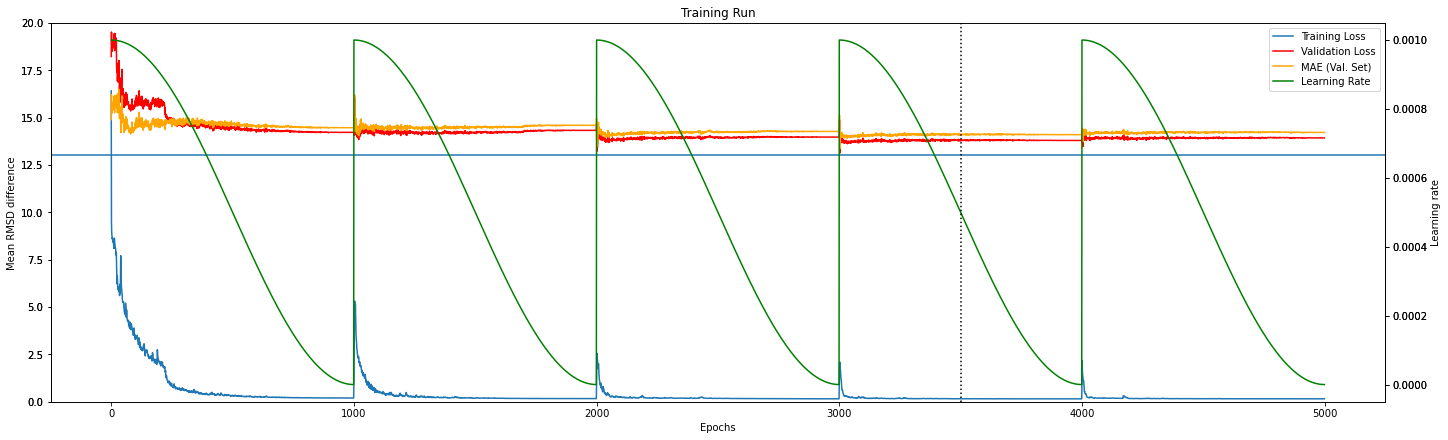

In [28]:
#plot the training run
select = 3502
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2)
plt.draw()

Test Set
tensor([[27.5580]], device='cuda:0') tensor([[27.4454]], device='cuda:0') 0.006342208944261074
tensor([[0.0850]], device='cuda:0') tensor([[31.0637]], device='cuda:0') 30.478666305541992
Mean Test loss: 	 10.6358
Std. Dev. of Test loss:  6.9695
Min loss: 		 0.0063
First Quantile: 	 5.5138
Median: 		 9.5203
Third Quantile: 	 16.3404
Max Loss: 		 30.4787
LinregressResult(slope=0.6482725613310373, intercept=2.739297630888501, rvalue=0.3026884862435042, pvalue=2.807324669460474e-07, stderr=0.12309179281839125, intercept_stderr=2.768971190033986)


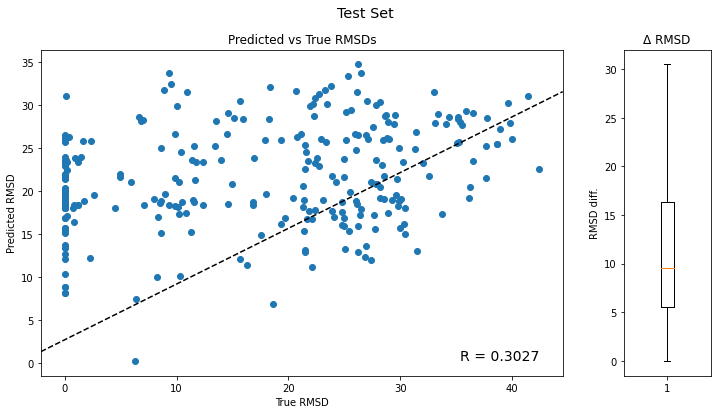

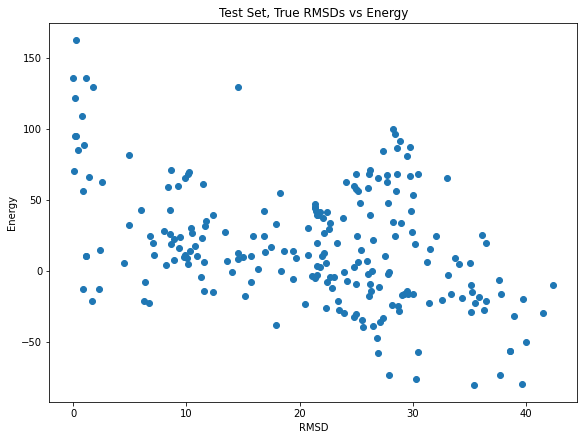

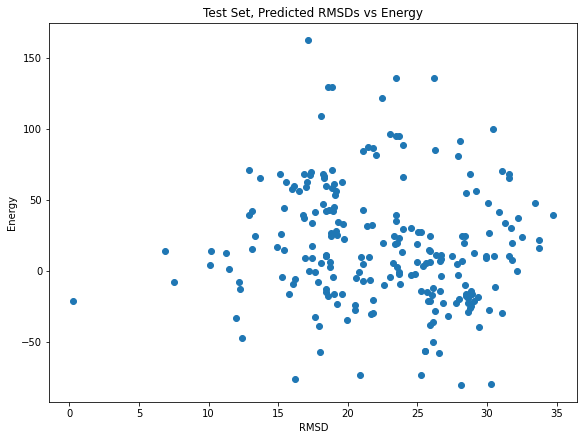

5S and tRNA Test Set
tensor([[20.4110]], device='cuda:0') tensor([[20.4102]], device='cuda:0') 2.95420250040479e-07
tensor([[0.]], device='cuda:0') tensor([[32.6560]], device='cuda:0') 32.15596389770508
Mean Test loss: 	 5.7869
Std. Dev. of Test loss:  6.2424
Min loss: 		 0.0000
First Quantile: 	 1.3203
Median: 		 3.5856
Third Quantile: 	 7.9025
Max Loss: 		 32.1560
LinregressResult(slope=0.6100652804788259, intercept=4.15944003871676, rvalue=0.5112984902485698, pvalue=3.483736944404285e-73, stderr=0.03118788446857448, intercept_stderr=0.6436537171412915)


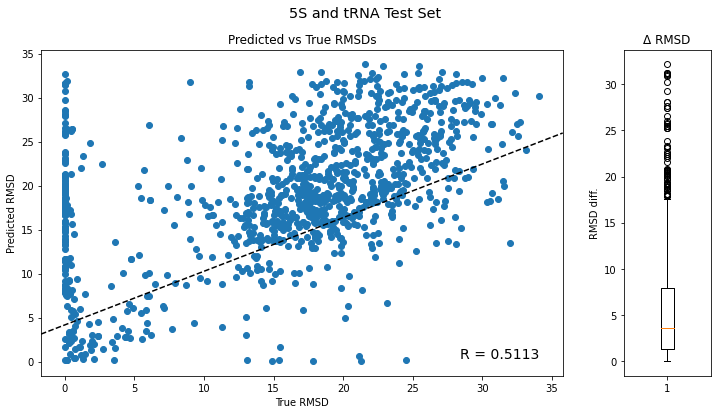

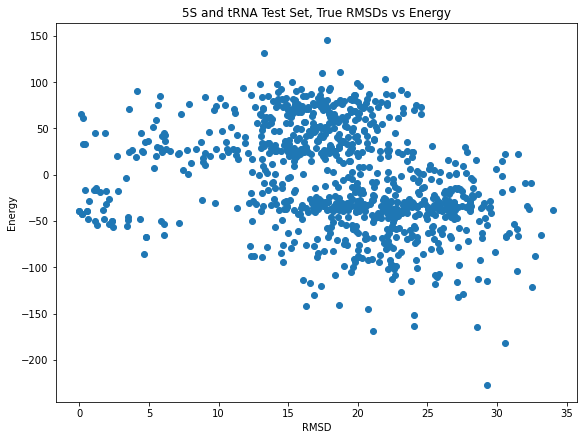

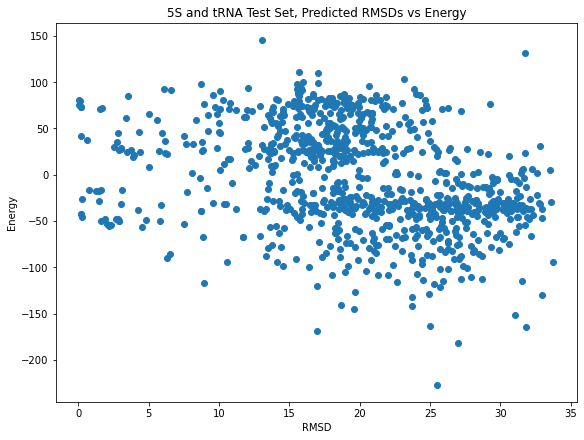

Training Set
tensor([[24.4880]], device='cuda:0') tensor([[24.4886]], device='cuda:0') 1.658991095609963e-07
tensor([[7.2250]], device='cuda:0') tensor([[15.8126]], device='cuda:0') 8.08761978149414
Mean Test loss: 	 0.4992
Std. Dev. of Test loss:  0.7694
Min loss: 		 0.0000
First Quantile: 	 0.0272
Median: 		 0.1695
Third Quantile: 	 0.7108
Max Loss: 		 8.0876
LinregressResult(slope=0.9652434253915361, intercept=0.18753462053597403, rvalue=0.9930614370841224, pvalue=0.0, stderr=0.004151654842530424, intercept_stderr=0.0856769699552005)


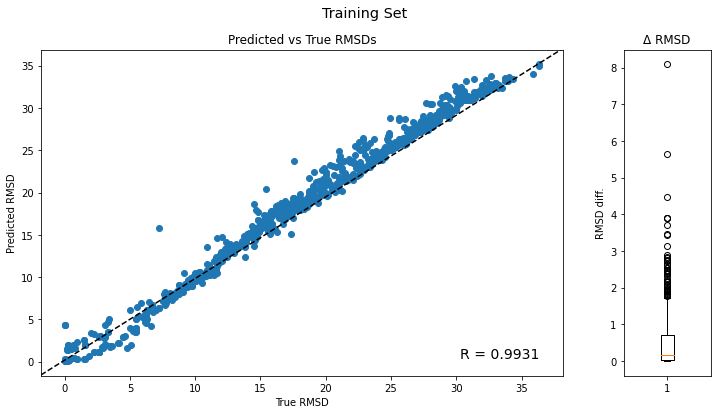

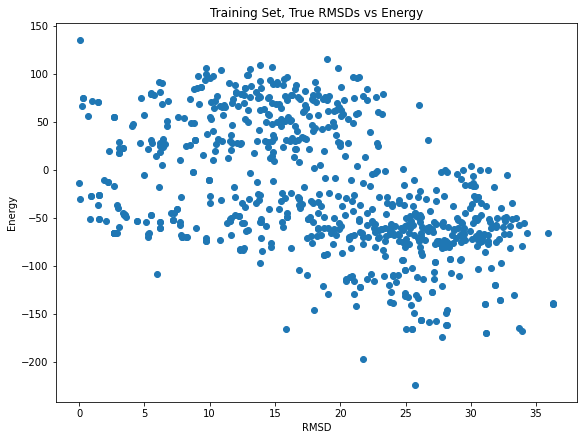

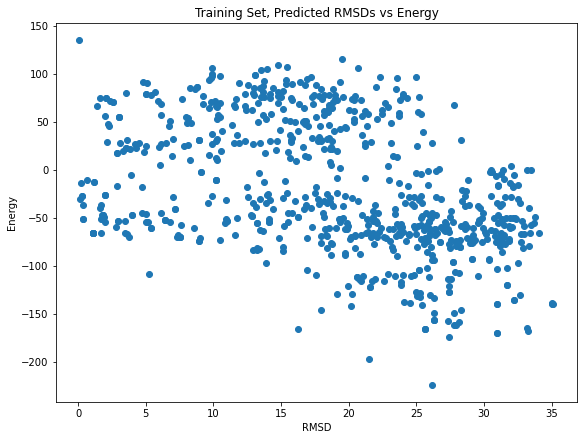

Validation Set
tensor([[16.1150]], device='cuda:0') tensor([[15.9891]], device='cuda:0') 0.007926039397716522
tensor([[61.9850]], device='cuda:0') tensor([[12.6381]], device='cuda:0') 48.84685516357422
Mean Test loss: 	 12.9365
Std. Dev. of Test loss:  9.4146
Min loss: 		 0.0079
First Quantile: 	 5.2117
Median: 		 11.4249
Third Quantile: 	 18.5968
Max Loss: 		 48.8469
LinregressResult(slope=0.35552463513384286, intercept=15.416278229712983, rvalue=0.13250275214773138, pvalue=0.008288485158979108, stderr=0.1339832090640343, intercept_stderr=3.057242842384217)


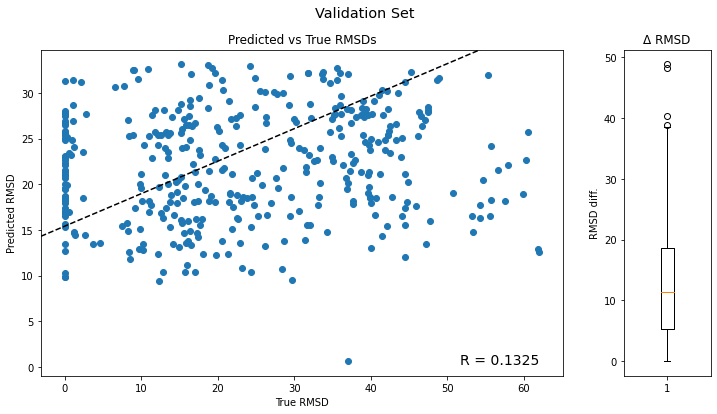

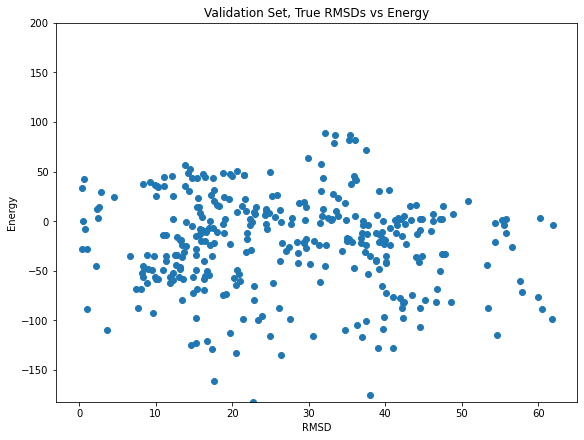

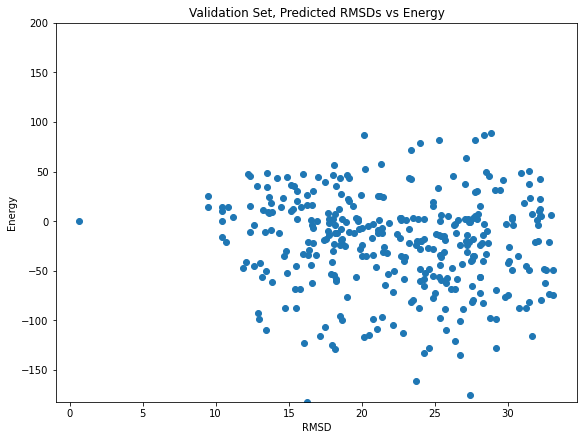

LinregressResult(slope=0.5251746533518253, intercept=9.900746992409616, rvalue=0.3589941014086326, pvalue=1.4049015817924598e-46, stderr=0.035384160363285545, intercept_stderr=0.775206744676458)


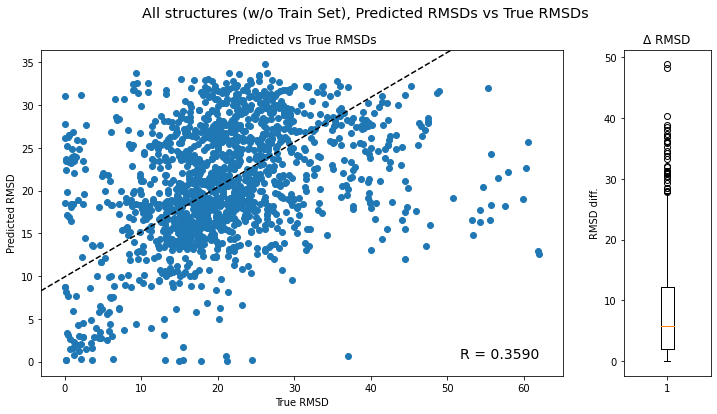

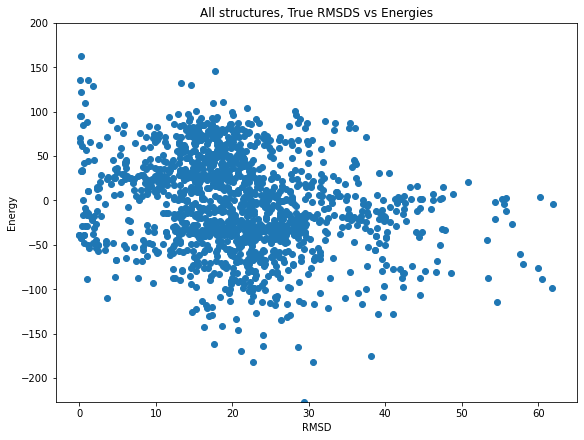

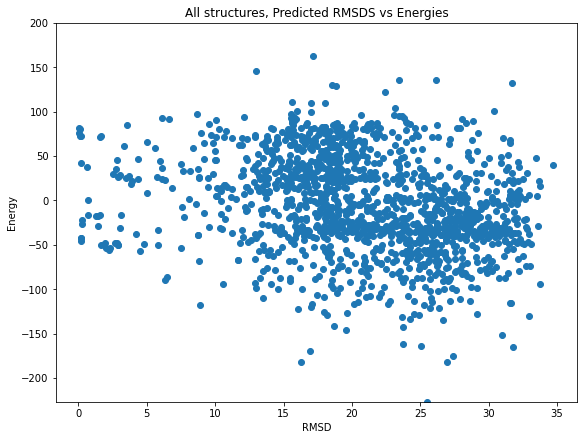

In [4]:
#Test
from pyg_classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = Diff_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load("pyg_diff_model_data/2022-04-05_model_k3v_diff_ep4230.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = diff_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.11515777487685246, intercept=18.35121181482273, rvalue=0.12173363406707649, pvalue=0.04292648629127923, stderr=0.05662058177005735, intercept_stderr=1.2795737179353275)


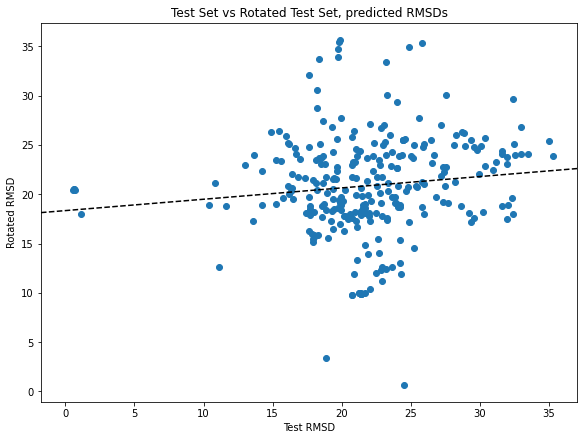

LinregressResult(slope=0.5909290205514608, intercept=3.542066492753528, rvalue=0.6440634348300032, pvalue=7.469686683713563e-34, stderr=0.04232392301604128, intercept_stderr=0.5986293020801253)


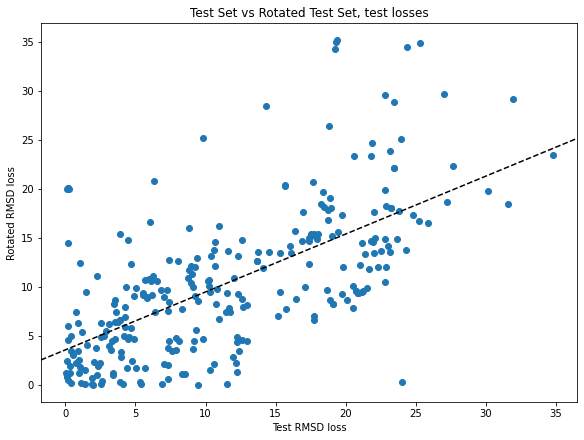

LinregressResult(slope=0.23156782931831726, intercept=16.64940626391158, rvalue=0.3995945460553535, pvalue=8.805521780927139e-43, stderr=0.01615731755561036, intercept_stderr=0.32420507148619143)


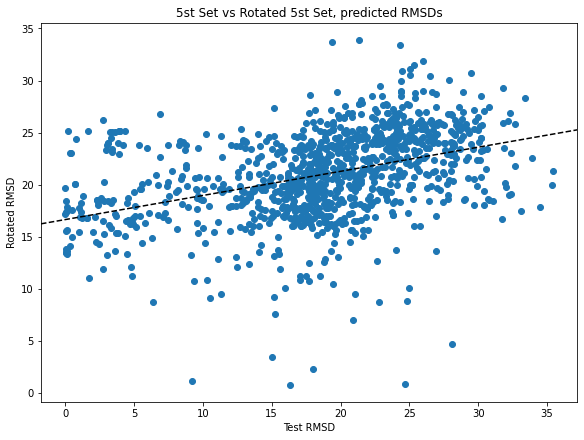

LinregressResult(slope=0.6279008297811258, intercept=3.5432904094897433, rvalue=0.5507030612052042, pvalue=6.579001275640447e-87, stderr=0.0289462141855114, intercept_stderr=0.21641411316283599)


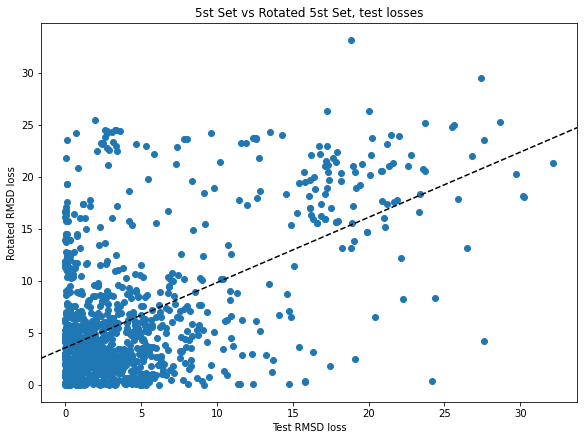

In [27]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")